In [1]:
import tensorflow as tf
import numpy as np
import t3f
tf.set_random_seed(0)
np.random.seed(0)
%matplotlib inline
import matplotlib.pyplot as plt
import metric_util as mt
import data_util as du
from t3f import shapes
from nilearn import image
from skimage.measure import compare_ssim as ssim
from tensorflow.python.util import nest
import copy
from nilearn import plotting
from t3f import ops
import mri_draw_utils as mrd
from t3f import initializers
from t3f import approximate
from scipy import optimize 
from nilearn.masking import compute_background_mask
from nilearn.masking import compute_epi_mask
from collections import OrderedDict
import pandas as pd

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
#sess = tf.InteractiveSession()

In [3]:
def frobenius_norm_tf_squared(x):
    return tf.reduce_sum(x ** 2)

In [4]:
def frobenius_norm_tf(x):
    return tf.reduce_sum(x ** 2) ** 0.5

In [5]:
def relative_error1(x_hat,x_true):
    percent_error = frobenius_norm_tf(x_hat - x_true) / frobenius_norm_tf(x_true)
    return percent_error

In [6]:
def innerProduct(x, y):
    result = tf.reduce_sum(tf.multiply(x, y))
    return result

In [7]:
def compute_step_size(n_omega, grad):
    result = -innerProduct(n_omega,grad)/(innerProduct(n_omega, n_omega))
    return result

In [8]:
def draw(omega, x_true, x_hat, rel_error):
    images_folder = "/work/scratch/tt3"
    ten_ones = np.ones_like(omega)
    x_reconstr1 = mt.reconstruct2(x_hat,ground_truth, omega)
    x_hat_img = mt.reconstruct_image_affine(x_true_org, x_reconstr1)
    x_hat_est = image.index_img(x_hat_img,1)
    
    x_true_org_img = image.index_img(x_true,1)
    x_miss_img = mt.reconstruct_image_affine(x_true_org, x_train)
    x_miss = image.index_img(x_miss_img,1)
    mrd.draw_original_vs_reconstructed_rim(x_true_org_img,x_hat_est, x_miss, "Rim Completion",
                                             rel_error, observed_ratio, coord=None, folder=images_folder)

In [9]:
subject_scan_path = du.get_full_path_subject1()
print "Subject Path: " + str(subject_scan_path)
x_true_org = mt.read_image_abs_path(subject_scan_path)


Subject Path: /work/pl/sch/analysis/data/COBRE001/swaAMAYER+cobre01_63001+M87100944+20110309at135133+RSTpre_V01_R01+CM.nii


In [10]:
def get_mask(data, observed_ratio):
    
    if len(data.shape) == 3:
        mask_indices = (np.random.rand(data.shape[0],data.shape[1],data.shape[2]) < observed_ratio).astype('int') 
    elif len(data.shape) == 4:
        mask_indices = (np.random.rand(data.shape[0],data.shape[1],data.shape[2], data.shape[3]) < observed_ratio).astype('int') 
    elif len(data.shape) == 2:
        mask_indices = (np.random.rand(data.shape[0],data.shape[1]) < observed_ratio).astype('int') 
    
    return mask_indices

In [130]:
x_true_img = np.array(x_true_org.get_data())

mask_img = compute_epi_mask(x_true_org)
mask_img_data = np.array(mask_img.get_data())

observed_ratio = 0.2
missing_ratio = 1 - observed_ratio

mask_indices = get_mask(x_true_img, observed_ratio)
epi_mask = copy.deepcopy(mask_img_data)
    
mask_indices[epi_mask==0] = 1



#x_true_img = np.array(x_true_org.get_data())

norm_ground_truth = np.linalg.norm(x_true_img)
x_true_img = x_true_img * (1./norm_ground_truth)

#mask_indices = (np.random.rand(x_true_img.shape[0],x_true_img.shape[1],x_true_img.shape[2], x_true_img.shape[3]) < observed_ratio).astype('int') 
ten_ones = np.ones_like(mask_indices)
x_train = copy.deepcopy(x_true_img)
x_train[mask_indices==0] = 0.0
#x_train[mask_indices == 0] = np.mean(x_train[mask_indices == 1])
#x_train[mask_indices == 0] = np.mean(x_train[mask_indices == 1])

x_init = copy.deepcopy(x_train)
#shape = (1, 53, 63, 63, 1)
#x_init_tf = t3f.random_tensor(shape, tt_rank=63)


ground_truth = copy.deepcopy(x_true_img)
a_omega = copy.deepcopy(ground_truth)
a_omega[mask_indices==0] = 0.0

sparse_observation = copy.deepcopy(ground_truth)
sparse_observation[mask_indices==0] = 0.0

In [12]:
norm_ground_truth

74916430.0

In [13]:
folder = '/work/rs1/'

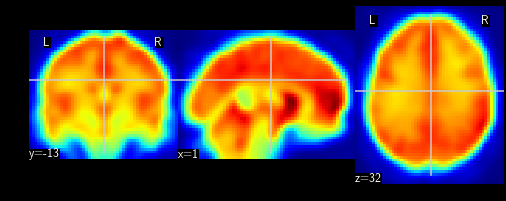

In [14]:
x_org = mt.reconstruct_image_affine(x_true_org, x_true_img)
x_org_img = image.index_img(x_org,1)
#x_true_org_img = image.index_img(x_true_org,1)
org_image = plotting.plot_epi(x_org_img, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

In [15]:
ten_ones = np.ones_like(mask_indices)


In [16]:
norm_sparse_observation = np.linalg.norm(sparse_observation)
print norm_sparse_observation

0.5210458


In [17]:
mask_indices_tf = t3f.to_tt_tensor(mask_indices.astype('float32'), max_tt_rank=63)

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]


In [136]:
#x_miss_img = mt.reconstruct_image_affine(x_true_org, x_train*norm_ground_truth)
x_miss_img = mt.reconstruct_image_affine(x_true_org, x_train)

In [19]:
x_miss = norm_ground_truth*x_train

In [138]:
x_miss = image.index_img(x_miss_img,1)

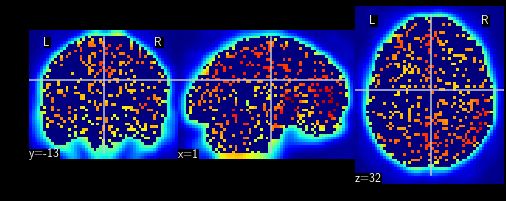

In [140]:
x_miss_image = plotting.plot_epi(x_miss, bg_img=None,black_bg=True, cmap='jet', cut_coords=[1, -13, 32]) 

In [22]:
images_folder = "/work/scratch/tt3"
mrd.draw_original_vs_reconstructed_rim(image.index_img(x_true_org,1),image.index_img(x_miss_img,1), image.index_img(x_miss_img,1), "Rim Completion",
                                             observed_ratio, observed_ratio, coord=None, folder=images_folder)

('Saving figure', '/work/scratch/tt3/missing_ratio_80.00.png')
Called from mrd


In [23]:
import nibabel as nib
import os

suffix = int(round((missing_ratio)*100.0, 0))
print "Missing Ratio: " + str(missing_ratio)
x_true_path = os.path.join(folder,"x_true_img_" + str(suffix))
x_miss_path = os.path.join(folder,"x_miss_img_" + str(suffix))
        
print("x_true_path:" + str(x_true_path))
nib.save(x_true_org, x_true_path)
nib.save(x_miss_img, x_miss_path)

Missing Ratio: 0.8
x_true_path:/work/rs1/x_true_img_80


In [24]:
ground_truth_tf = t3f.to_tt_tensor(ground_truth, max_tt_rank=63)

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]


In [25]:
A = t3f.get_variable('A', initializer=ground_truth_tf, trainable=False)

In [26]:
ground_truth = tf.get_variable('ground_truth', initializer=ground_truth, trainable=False)
sparsity_mask = tf.get_variable('sparsity_mask', initializer=mask_indices, trainable=False)
sparsity_mask = tf.cast(sparsity_mask,tf.float32)
sparse_observation = ground_truth * sparsity_mask

In [27]:
#sparsity_mask = t3f.get_variable('sparsity_mask', initializer=mask_indices_tf, trainable=False)
#sparsity_mask = t3f.cast(sparsity_mask, tf.float32)
#sparse_observation_tf = t3f.to_tt_tensor(sparse_observation, max_tt_rank=63)
#sparse_observation_tf3 = t3f.get_variable('sparse_observation_tf', initializer=sparse_observation_tf, trainable=False)

In [28]:
shape  =  (53, 63, 46, 144)

In [29]:


x_init1 = np.random.rand(53, 63, 46, 144).astype('float32')
norm_ground_x_init1 = np.linalg.norm(x_init1)
x_init1 = x_true_img * (1./norm_ground_x_init1)

In [30]:
x_train_tf = t3f.to_tt_tensor(x_init1, max_tt_rank=63)

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]


In [31]:
#x_train_tf = t3f.random_tensor(shape, tt_rank=63)

In [32]:
normAOmegavar = tf.get_variable('normAOmega', initializer=norm_sparse_observation, trainable=False)

In [33]:
X = t3f.get_variable('X', initializer=x_train_tf)

In [34]:
X_new = t3f.get_variable('X_new', initializer=x_train_tf)

In [35]:
print X

A Tensor Train variable of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [36]:
def train_it_rel_cost(cost_hist, k):
    res = np.abs(cost_hist[k] - cost_hist[k-1])/np.abs(cost_hist[k])
    return res

In [37]:
counter = tf.get_variable('counter', initializer=0)

In [38]:
one = tf.constant(1)
zero_point1 = tf.constant(0.1)

In [39]:
tt_zeros = initializers.tensor_zeros([53, 63, 46, 144])

In [40]:
#eta_t3f_old = t3f.get_variable('eta_t3f_old', initializer=tt_zeros)
#grad_t3f_old = t3f.get_variable('grad_t3f_old', initializer=tt_zeros)

In [41]:
eta_old = tf.get_variable('eta_old', shape = (53, 63, 46, 144), validate_shape=False)
grad_old = tf.get_variable('grad_old', shape = (53, 63, 46, 144), validate_shape=False)

In [42]:
one = tf.constant(1)
zero_point1 = tf.constant(0.1)

In [43]:


def gradient(x):
    return np.multiply(x,mask_indices) - a_omega
    
def cost_func(x):
    return 0.5*(np.linalg.norm(np.multiply(x,mask_indices)-a_omega)** 2)

def find_step_size(x,g,d, old_cost):
    step_size = optimize.line_search(cost_func,gradient,x,d,gfk=None, old_fval=old_cost)

In [44]:
# Algorithm
#grad_full = (t3f.full(X)*t3f.full(sparse_observation_tf3) - t3f.full(sparse_observation_tf3))
#counter_step = tf.assign(counter, counter + 1)

#grad_trans = t3f.riemannian.project(grad_t3f_old, X)
#eta_trans = t3f.riemannian.project(eta_t3f_old, X)
    
#grad_full = sparsity_mask * t3f.full(X) - sparse_observation
#grad_t3f = t3f.to_tt_tensor(grad_full, max_tt_rank=63)

#loss = 0.5 * t3f.frobenius_norm_squared(grad_t3f)
#gradnorm_omega = t3f.frobenius_norm(grad_t3f)/(normAOmegavar)

#riemannian_grad = t3f.riemannian.project(grad_t3f, X)


#eta_omega = sparsity_mask * t3f.full(-riemannian_grad)
#alpha = compute_step_size(eta_omega, grad_full)



#riemannian_grad_norm = t3f.flat_inner(riemannian_grad, riemannian_grad)



#rel_error1 = relative_error1(t3f.full(X), t3f.full(sparse_observation))




In [45]:
eps = 1e-5
epsilon_train=1e-4

In [46]:
#print grad_full

In [47]:
#print grad_t3f

In [48]:
print eps

1e-05


In [49]:
#alpha = 0.3


In [50]:
#sess = tf.Session()
#sess.run(tf.global_variables_initializer())

In [51]:
def compute_loss(x):
    return 0.5*frobenius_norm_tf_squared(sparsity_mask * t3f.full(x) - sparse_observation)

In [52]:
def tsc(x_hat,x_true, ten_ones, mask):
    nomin = np.linalg.norm(np.multiply((ten_ones - mask), (x_true - x_hat)))
    denom = np.linalg.norm(np.multiply((ten_ones - mask), x_true))
    score = nomin/denom
    return score  

In [53]:
def tsc_tf(x_hat,x_true_omega, mask):
    score = frobenius_norm_tf(sparsity_mask * x_hat - sparse_observation)/normAOmegavar
    return score  


In [54]:
#first step

In [55]:
zero_point1 = tf.constant(0.1)
backtack_const = tf.constant(1e-4)

initial_cost = compute_loss(X)
cost = tf.get_variable('cost', initializer=initial_cost)
cost_new = tf.get_variable('cost_new', initializer=0.0)

tsc_score_curr = tsc_tf(t3f.full(X),ground_truth, sparse_observation)
completion_score = tf.get_variable('completion_score', initializer=tsc_score_curr)

grad_full_0 = sparsity_mask * t3f.full(X) - sparse_observation
grad_t3f_0 = t3f.to_tt_tensor(grad_full_0, max_tt_rank=63)

gradnorm_omega_0 = t3f.frobenius_norm(grad_t3f_0)/(normAOmegavar)
riemannian_grad_0 = t3f.riemannian.project(grad_t3f_0, X)
riemannian_grad_0 = t3f.round(riemannian_grad_0, max_tt_rank =63, epsilon = 1e-15)

grad_t3f_old = t3f.get_variable('grad_t3f_old', initializer=riemannian_grad_0)

#grad_t3f_old_op = t3f.assign(grad_t3f_old, riemannian_grad_0, validate_shape=False)
riemannian_grad_full_0 = t3f.full(riemannian_grad_0)
riemannian_grad_init_op = tf.assign(grad_old,riemannian_grad_full_0)

eta_t3f_0 = -riemannian_grad_0
eta_t3f_old = t3f.get_variable('eta_t3f_old', initializer=eta_t3f_0)

eta_0 = -riemannian_grad_init_op
eta_omega_0 = sparsity_mask * t3f.full(-riemannian_grad_0)

alpha_0 = compute_step_size(eta_omega_0, riemannian_grad_init_op)
eta_op_0 = tf.assign(eta_old,eta_0, validate_shape=False)

eta_norm = tf.get_variable('eta_norm', initializer=0.0)
eta_norm_init_op = tf.assign(eta_norm, frobenius_norm_tf(eta_op_0))

alpha_old = tf.get_variable('alpha_old', initializer=0.0)

train_step_0 = t3f.assign(X, t3f.round(X - alpha_0 * eta_t3f_0, max_tt_rank=63))



[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]
Max_TT rank63
[1, 53, 63, 63, 1]
Max_TT rank63
[1, 53, 63, 63, 1]


In [56]:
print "Rim 0:" + str(riemannian_grad_0)

Rim 0:A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [57]:
print "Eta 0: " + str(eta_t3f_0)

Eta 0: A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [58]:
#tt = t3f.round(eta_t3f_old, max_tt_rank =63, epsilon = 1e-15

In [59]:
# new
#t3f.assign(eta_t3f_old, t3f.round(eta_t3f_old, max_tt_rank =63, epsilon = 1e-15))


In [60]:
counter_step = tf.assign(counter, counter + 1)

grad_trans = t3f.riemannian.project(grad_t3f_old, X)
eta_trans = t3f.riemannian.project(eta_t3f_old, X)
    
grad_full = sparsity_mask * t3f.full(X) - sparse_observation
grad_t3f = t3f.to_tt_tensor(grad_full, max_tt_rank=63)


loss = 0.5 * t3f.frobenius_norm_squared(grad_t3f)
gradnorm_omega = t3f.frobenius_norm(grad_t3f)/(normAOmegavar)

riemannian_grad =  t3f.round(t3f.riemannian.project(grad_t3f, X),max_tt_rank =63)
#riemannian_grad = t3f.round(riemannian_grad, max_tt_rank =63, epsilon = 1e-15)
riemannian_grad_norm = t3f.frobenius_norm(riemannian_grad)

inner_product_rim_grad = t3f.flat_inner(riemannian_grad, riemannian_grad)
ip_xitrans_xi = t3f.flat_inner(grad_trans,riemannian_grad)
theta = ip_xitrans_xi / inner_product_rim_grad

def get_theta():
    return t3f.full(ip_xitrans_xi / inner_product_rim_grad)

def get_value_zero_point1():
    return zero_point1
    
def get_conj_dir():
    print "conjugate gradient"
    tf.Print(zero_point1,[zero_point1],message="conjugate gradient")
    return t3f.full(approximate.add_n([-riemannian_grad, beta*eta_trans], max_tt_rank=63))

def get_rim_grad():
    print "steepest descent"
    tf.Print(zero_point1,[zero_point1],message="steepest descent")
    return t3f.full(-riemannian_grad)

# compute beta
inner_product_rim_grad_old = t3f.flat_inner(grad_t3f_old, grad_t3f_old)
beta = tf.maximum(0.0, (inner_product_rim_grad - ip_xitrans_xi)/inner_product_rim_grad_old)
#eta = -riemannian_grad + beta*eta_trans

print "Rim Grad shape: " + str(riemannian_grad)
print "eta_trans: " + str(eta_trans)

eta_cond = tf.cond((tf.abs(theta) >= zero_point1), get_rim_grad, get_conj_dir)
eta_norm_update_op = tf.assign(eta_norm, frobenius_norm_tf(eta_cond))

#eta = tf.case([(tf.greater_equal(theta_full,zero_point1), get_rim_grad)], default=get_conj_dir, exclusive=True)
#eta = approximate.add_n([-riemannian_grad, beta*eta_trans], max_tt_rank=63)
eta = t3f.to_tt_tensor(eta_cond, max_tt_rank=63)

inprod_grad_eta = t3f.flat_inner(riemannian_grad,eta)
#
#eta_full = t3f.full(eta)

print "eta: " + str(eta)
#print "eta1: " + str(eta1)
                                            
#(1, 106, 126, 126, 1)

eta_omega = sparsity_mask * t3f.full(eta)
alpha = compute_step_size(eta_omega, grad_full)

#two = tf.constant(2.0)
#alpha1 =tf.maximum(0.0,two*(cost_new - cost)/inprod_grad_eta)

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]
Max_TT rank63
[1, 53, 63, 63, 1]
Rim Grad shape: A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)
eta_trans: A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 106, 126, 126, 1)
steepest descent
conjugate gradient
Max_TT rank63
[1, 53, 63, 63, 1]
[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]
eta: A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [61]:
#eta1 = tf.cond((theta > zero_point1), get_rim_grad, get_conj_dir)

In [62]:
print eta

A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [63]:
#cost_old_update = compute_loss(X)
#cost_old_op = tf.assign(cost_old,cost_old_update)

In [64]:
train_new_step = t3f.assign(X_new, t3f.round(X + alpha * eta, max_tt_rank=63))

Max_TT rank63
[1, 53, 63, 63, 1]


In [65]:
updated_cost_new = compute_loss(train_new_step)
cost_new_op = tf.assign(cost_new,updated_cost_new)

In [66]:
tsc_score_new = tsc_tf(t3f.full(train_new_step),ground_truth, sparse_observation)
tsc_score_op = tf.assign(completion_score,tsc_score_new)

In [67]:
train_step = t3f.assign(X, t3f.round(X + alpha * eta, max_tt_rank=63))

Max_TT rank63
[1, 53, 63, 63, 1]


In [68]:
tsc_score_update = tsc_tf(t3f.full(X_new),ground_truth, sparse_observation)
tsc_score_update_op = tf.assign(completion_score,tsc_score_update)

In [69]:
updated_cost = compute_loss(train_step)
cost_op = tf.assign(cost,updated_cost)

In [70]:
eta_update_op = t3f.assign(eta_t3f_old, eta,use_locking = True)

In [71]:
grad_update_op = t3f.assign(grad_t3f_old, riemannian_grad)

In [72]:
print alpha_0

Tensor("div_2:0", shape=(), dtype=float32)


In [73]:
print theta

Tensor("div_4:0", shape=(), dtype=float32)


In [74]:
print zero_point1

Tensor("Const_7:0", shape=(), dtype=float32)


In [75]:
#t3f.round(-riemannian_grad + beta*eta_trans, max_tt_rank=[eta_trans])

In [76]:
#eta_update_op = t3f.assign(eta_t3f_old, eta,validate_shape=False, use_locking = True)

In [77]:
#grad_update_op = t3f.assign(grad_t3f_old, riemannian_grad)

In [78]:
tsc_score_history = []

In [79]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [80]:
log = []
train_loss_hist = []
#for i in range(1000):
gradnorm_val, alpha_val, eta_op_0_val,cost_val, cost_new_val, eta_norm_val, tsc_score_val,_,_ = sess.run([gradnorm_omega_0, alpha_0, eta_op_0, cost, cost_new, eta_norm,completion_score, train_step_0.op, eta_norm_init_op.op])
print gradnorm_val, alpha_val,cost_val, cost_new_val, eta_norm_val

0.69150764 1.0 0.13565847 0.0 0.35087937


In [81]:
print grad_trans

A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 106, 126, 126, 1)


In [82]:
tsc_score_0 = tsc_score_val

In [83]:
print "tsc_score_0:" + str(tsc_score_0)

tsc_score_0:0.99968356


In [84]:
tsc_score_history.append(tsc_score_0)

In [85]:
#x_k, grad_k, eta_k = sess.run([t3f.full(X),t3f.full(grad_t3f_old), t3f.full(eta_t3f_old)])

In [86]:
#scipy_step_size = find_step_size(x_k,grad_k,eta_k, cost_old_val)

In [87]:
#print "scipy_step_size: " + str(scipy_step_size)

In [88]:
#sess.run([loss])

In [89]:
#sess.run([theta])

In [90]:
#print theta

In [91]:
#sess.run([eta_trans])

In [92]:
#sess.run([eta])

In [93]:
#sess.run([train_step.op])

In [94]:
#def backtrack(t, sess):
#    t = t * 0.5
#    return t3f.assign(X, t3f.round(X - t * eta, max_tt_rank=63))

In [95]:
def loss_func(x, y):
    return 0.5*(np.linalg.norm(x - y)** 2)
    

In [96]:
def is_nan(x):
    return (x is np.nan or x != x)

In [97]:
backtrack_const = 1e-4 

In [98]:
cost_history = []


In [99]:
#sess.run([loss, gradnorm_omega, alpha, theta, eta_update_op, grad_update_op, train_step.op])

In [100]:


i = 0
cost_nan = False
while gradnorm_val > eps:   
#for k in range(20):
    i = i + 1
    F_v, gradnorm_val, alpha_val,theta_val, beta_val, cost_new_val, cost_val,tsc_score_val, eta_norm_val, inprod_grad_eta_val, riemannian_grad_norm_val,_, _,_,_,_,_ = sess.run([loss, gradnorm_omega, alpha, theta, beta, cost_new, cost, completion_score, eta_norm, inprod_grad_eta, riemannian_grad_norm,eta_norm_update_op.op, cost_new_op.op, train_new_step.op, tsc_score_op.op, eta_update_op.op, grad_update_op.op])
    #eta_old_val, grad_update_val,_ = sess.run([eta_update_op, grad_update_op])
    
    print "alpha_val: " + str(alpha_val)
    print "theta_val: " + str(theta_val)
    print "inprod_grad_eta_val: " + str(inprod_grad_eta_val)
    print "rim_grad_norm: " + str(riemannian_grad_norm_val)
    print "eta_norm_val: " + str(eta_norm_val)
    
    lr = alpha_val
    cost_prev_value = cost_val
    cost_new_value = cost_new_val
    cost_0 = cost_val
    
    print "Cost New: " +str(cost_new_value)
    print "Cost Old: " +str(cost_prev_value)
        
    tsc_score_old = tsc_score_history[i-1]
    
    tsc_score_new = tsc_score_val
    print "TSC Score New: " +str(tsc_score_val)
    print "TSC Score Old: " +str(tsc_score_old)
       
    backtrackiter = 0

    max_iter_count = 10
    #armijo = (cost_new_val <= cost_prev_value + backtrack_const*(lr)*inprod_grad_eta_val)
    armijo = ((tsc_score_new < tsc_score_old) or (cost_new_val <= cost_prev_value + backtrack_const*(lr)*inprod_grad_eta_val))
    print "armijo: " + str(armijo)
    
    proposed_initial_alpha = 2*(cost_new_value - cost_prev_value)/inprod_grad_eta_val
    print "proposed_initial_alpha: " + str(proposed_initial_alpha)
    
    #diff_train = np.abs(train_loss_hist[i - 1] - train_loss_hist[i-2])
    
    #while (cost_prev - cost_new) <= -backtrack_const*(-lr)*inprod_grad_eta_val:
    #while (not (cost_new <= cost_prev + backtrack_const*(lr)*inprod_grad_eta_val)):
    while ((tsc_score_new > tsc_score_old) or (cost_new_value > cost_prev_value + backtrack_const*(lr)*inprod_grad_eta_val)):
        
        print "Backtracking"
        lr = 0.5*lr
        print "Learning Rate: " + str(lr)
        sess.run(t3f.assign(X_new, t3f.round(X + lr * eta_t3f_old, max_tt_rank=63)).op)
        x_new_val = sess.run(t3f.full(X_new))
        x_new_val[mask_indices==0] = 0.0
        
               
        print "proposed_initial_alpha: " + str(proposed_initial_alpha)
        proposed_step_size = proposed_initial_alpha /inprod_grad_eta_val
        print "proposed_step_size: " + str(proposed_step_size)
        proposed_initial_alpha = 0.5* proposed_step_size
        
        cost_new_value = loss_func(x_new_val, a_omega)
        sess.run(tf.assign(cost_new,cost_new_value).op)
        
        tsc_score_new,_ = sess.run([completion_score, tsc_score_update_op.op])
        print "TSC Score New: " +str(tsc_score_new)
        print "TSC Score Old: " +str(tsc_score_old)
        
        if is_nan(cost_new):
            cost_nan = True
            break
        
        print "Cost New: " +str(cost_new_value)
        print "Cost Old: " +str(cost_prev_value)
        backtrackiter = backtrackiter + 1
        print "backtrackiter_count: " + str(backtrackiter)
    
        if cost_nan:
            print "Cost is Nan. Breaking after " + str(i) + "; iterations"
            break
        
        if backtrackiter>= max_iter_count:
           print "Breaking after " + str(i) + "; iterations"
           break
    
    
    
    if (cost_new_value < cost_prev_value or (tsc_score_new <= tsc_score_old)):
        # update x
        print "updating X: initial cost: " + str(cost_prev_value) + "; New Cost: " +  str(cost_new_value)
        sess.run([t3f.assign(X, X_new).op, tf.assign(cost,cost_new_value).op])
        tsc_score_history.append(tsc_score_new)
    else:
        print "Reject Step: not updating X: initial cost: " + str(cost_prev_value) + "; New Cost: " +  str(cost_new_value)
        tsc_score_history.append(tsc_score_old)
        
    train_loss_hist.append(gradnorm_val)
    cost_history.append(cost_new_value)
    
    if i > 1:
        diff_train = np.abs(train_loss_hist[i - 1] - train_loss_hist[i-2])/np.abs(train_loss_hist[i-1])
        print (F_v, i, gradnorm_val, diff_train, alpha_val, theta_val, beta_val, cost_val, cost_new_val)
        if diff_train <= epsilon_train:
            print "Breaking after " + str(i) + " iterations"
            break
    else:
        print (F_v, i, gradnorm_val, alpha_val, theta_val, beta_val, cost_val, cost_new_val)
    log.append(F_v)

alpha_val: 1.131648
theta_val: 0.5407598
inprod_grad_eta_val: -0.3966678
rim_grad_norm: 0.6298199
eta_norm_val: 0.6297775
Cost New: 0.079965845
Cost Old: 0.13565847
TSC Score New: 0.76752293
TSC Score Old: 0.99968356
armijo: True
proposed_initial_alpha: 0.28080235835366335
updating X: initial cost: 0.13565847; New Cost: 0.079965845
(0.20117962, 1, 1.2174089, 1.131648, 0.5407598, 1.4794635, 0.13565847, 0.079965845)
alpha_val: 3.9645019
theta_val: 0.024755184
inprod_grad_eta_val: -0.036880314
rim_grad_norm: 0.19185908
eta_norm_val: 0.20044865
Cost New: 0.0068345
Cost Old: 0.079965845
TSC Score New: 0.2243843
TSC Score Old: 0.76752293
armijo: True
proposed_initial_alpha: 3.965874288281678
updating X: initial cost: 0.079965845; New Cost: 0.0068345
(0.020341165, 2, 0.38715097, 2.1445327, 3.9645019, 0.024755184, 0.09047726, 0.079965845, 0.0068345)
alpha_val: 1.2487429
theta_val: 0.044633098
inprod_grad_eta_val: -0.007892047
rim_grad_norm: 0.08858072
eta_norm_val: 0.09800187
Cost New: 0.00185

alpha_val: 1.3177668
theta_val: -0.41482523
inprod_grad_eta_val: -5.526351e-07
rim_grad_norm: 0.0032484813
eta_norm_val: 0.0007433407
Cost New: 8.101108e-06
Cost Old: 8.367535e-06
TSC Score New: 0.007725228
TSC Score Old: 0.007851233
armijo: True
proposed_initial_alpha: 0.9642072733769668
updating X: initial cost: 8.367535e-06; New Cost: 8.101108e-06
(2.1908886e-06, 19, 0.007278307, 0.009972908, 1.3177668, -0.41482523, 1.2508501, 8.367535e-06, 8.101108e-06)
alpha_val: 1.2770119
theta_val: -0.41318965
inprod_grad_eta_val: -5.123718e-07
rim_grad_norm: 0.003242278
eta_norm_val: 0.0007157488
Cost New: 7.866619e-06
Cost Old: 8.101108e-06
TSC Score New: 0.0076126023
TSC Score Old: 0.007725228
armijo: True
proposed_initial_alpha: 0.915306631875337
updating X: initial cost: 8.101108e-06; New Cost: 7.866619e-06
(2.0722434e-06, 20, 0.0072180135, 0.008353178, 1.2770119, -0.41318965, 1.3102295, 8.101108e-06, 7.866619e-06)
alpha_val: 1.2274178
theta_val: -0.4480388
inprod_grad_eta_val: -4.5455548e-

(1.2792265e-06, 36, 0.0068013035, 0.0019071337, 1.0221945, -0.4957303, 1.4409347, 6.112121e-06, 6.0453767e-06)
alpha_val: 1.0192466
theta_val: -0.4953297
inprod_grad_eta_val: -2.2066543e-07
rim_grad_norm: 0.003196977
eta_norm_val: 0.00046971298
Cost New: 5.9805966e-06
Cost Old: 6.0453767e-06
TSC Score New: 0.006637604
TSC Score Old: 0.0066734557
armijo: True
proposed_initial_alpha: 0.5871343343541379
updating X: initial cost: 6.0453767e-06; New Cost: 5.9805966e-06
(1.2545113e-06, 37, 0.0067879055, 0.0019738057, 1.0192466, -0.4953297, 1.4558452, 6.0453767e-06, 5.9805966e-06)
alpha_val: 1.0118214
theta_val: -0.4891689
inprod_grad_eta_val: -2.163128e-07
rim_grad_norm: 0.0031962965
eta_norm_val: 0.0004650573
Cost New: 5.9172385e-06
Cost Old: 5.9805966e-06
TSC Score New: 0.0066023516
TSC Score Old: 0.006637604
armijo: True
proposed_initial_alpha: 0.5858010230158865
updating X: initial cost: 5.9805966e-06; New Cost: 5.9172385e-06
(1.2364666e-06, 38, 0.0067781066, 0.0014456707, 1.0118214, -0.

In [101]:
print "TSC Score Old: " +str(tsc_score_old)

TSC Score Old: 0.0064841076


In [102]:
print beta

Tensor("Maximum:0", shape=(), dtype=float32)


In [103]:
#sess.run([eta_update_op.op, grad_update_op.op])

In [104]:
print X

A Tensor Train variable of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [105]:
estimated_val = sess.run(t3f.full(X))

In [106]:
ground_truth_val = sess.run(ground_truth)


In [107]:
x_reconstr = mt.reconstruct(estimated_val,ground_truth_val, ten_ones, mask_indices)


In [108]:
def relative_error(x_hat,x_true):
    percent_error = np.linalg.norm(x_hat - x_true) / np.linalg.norm(x_true)
    return percent_error

In [109]:
rel_error = relative_error(estimated_val,ground_truth_val)

In [110]:
print rel_error

0.0061875368


In [111]:
rel_error_rec = relative_error(x_reconstr,ground_truth_val)

In [112]:
rel_error_rec

0.005193313922015152

In [141]:
x_miss_img = mt.reconstruct_image_affine(x_true_org, x_train)

In [142]:
x_miss = image.index_img(x_miss_img,1)

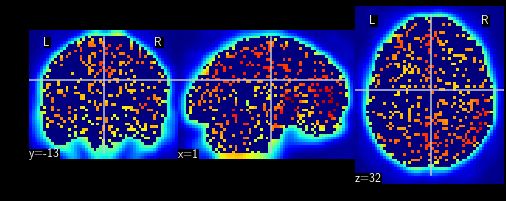

In [144]:
x_miss_image = plotting.plot_epi(x_miss, bg_img=None,black_bg=True, cmap='jet', cut_coords=[1, -13, 32]) 

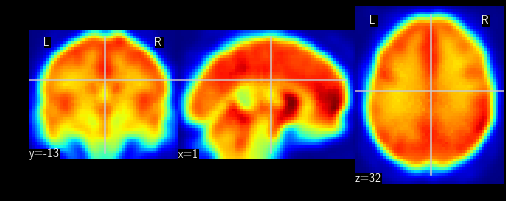

In [116]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, x_reconstr)
x_hat = image.index_img(x_hat_img,1)
recovered_image = plotting.plot_epi(x_hat, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

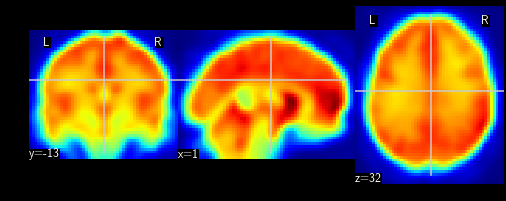

In [117]:
x_org = mt.reconstruct_image_affine(x_true_org, x_true_img)
x_org_img = image.index_img(x_org,1)
#x_true_org_img = image.index_img(x_true_org,1)
org_image = plotting.plot_epi(x_org_img, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

In [118]:
#x_true_org_img = image.index_img(x_true_org,1)
#org_image = plotting.plot_epi(x_true_org_img, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

In [145]:
images_folder = "/work/scratch/tt3/1"
mrd.draw_original_vs_reconstructed_rim(image.index_img(x_true_org,1),x_hat, image.index_img(x_miss_img,1), "4D fMRI Tensor Completion",
                                             rel_error_rec, observed_ratio, coord=None, folder=images_folder)

('Saving figure', '/work/scratch/tt3/1/missing_ratio_80.00.png')
Called from mrd


In [120]:
estimated_val_img = mt.reconstruct_image_affine(x_true_org, estimated_val)

In [121]:
estimated_val_hat = image.index_img(estimated_val_img,1)

In [122]:
images_folder = "/work/scratch/tt3/2"
mrd.draw_original_vs_reconstructed_rim(image.index_img(x_true_org,1),estimated_val_hat,image.index_img(x_miss_img,1), "4D fMRI Tensor Completion",
                                             rel_error_rec, observed_ratio, coord=None, folder=images_folder)

('Saving figure', '/work/scratch/tt3/2/missing_ratio_80.00.png')
Called from mrd


In [123]:
tsc_score = tsc(estimated_val,ground_truth_val, ten_ones, mask_indices)

In [124]:
tsc_score

0.006083625785882879

In [125]:
x_miss

In [126]:
print x_miss

<class 'nibabel.nifti1.Nifti1Image'>
data shape (53, 63, 46)
affine: 
[[  -3.    0.    0.   78.]
 [   0.    3.    0. -111.]
 [   0.    0.    3.  -51.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : 
db_name         : 
extents         : 0
session_error   : 0
regular         : 
dim_info        : 0
dim             : [ 3 53 63 46  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  3.  3.  3.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.00044231507
cal_min         : 1.3600151e-06
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : 
aux_file        : 
qform_code      : unknown
sform_code      : a

In [127]:
output_cost = OrderedDict()
indices = []

cost_arr = []
tsc_arr = []

counter = 0
for item in cost_history:
    print item
    cost_arr.append(item)
    indices.append(counter)
    counter = counter + 1
    
output_cost['k'] = indices
output_cost['cost'] = cost_arr
    
output_df = pd.DataFrame(output_cost, index=indices)

folder = '/work/rs1/'
fig_id = 'solution_cost'    
mrd.save_csv_by_path(output_df,folder,fig_id)  

tsc_score_output = OrderedDict()
tsc_score_indices = []

counter = 0
for item in tsc_score_history:
    tsc_arr.append(item)
    tsc_score_indices.append(counter)
    counter = counter + 1

tsc_score_output['k'] = tsc_score_indices
tsc_score_output['tsc_cost'] = tsc_arr
    
output_tsc_df = pd.DataFrame(tsc_score_output, index=tsc_score_indices)
fig_id = 'tsc_cost' 
mrd.save_csv_by_path(output_tsc_df,folder,fig_id)  

0.079965845
0.0068345
0.0018530457
0.0006500889
0.0003259281
0.00010200131
4.6280096e-05
2.8091328e-05
1.9979832e-05
1.586182e-05
1.3277683e-05
1.17527e-05
1.0758377e-05
1.0044714e-05
9.488374e-06
9.046734e-06
8.680829e-06
8.367535e-06
8.101108e-06
7.866619e-06
7.674368e-06
7.497714e-06
7.344072e-06
7.1990016e-06
7.067137e-06
6.942016e-06
6.828162e-06
6.7205397e-06
6.6178886e-06
6.5258523e-06
6.4306264e-06
6.342165e-06
6.260201e-06
6.1836e-06
6.112121e-06
6.0453767e-06
5.9805966e-06
5.9172385e-06
5.858142e-06
5.8030187e-06
5.754195e-06
5.7071884e-06
5.662544e-06
('Saving dataset', '/work/rs1/solution_cost.csv')
('Saving dataset', '/work/rs1/tsc_cost.csv')


In [128]:
cost_history[1]

0.0068345

In [129]:
import nibabel as nib
import os

suffix = int(round((missing_ratio)*100.0, 0))
print "Missing Ratio: " + str(missing_ratio)
x_true_path = os.path.join(folder,"x_true_img_" + str(suffix))
x_hat_path = os.path.join(folder,"x_hat_img_" + str(suffix))
x_miss_path = os.path.join(folder,"x_miss_img_" + str(suffix))
        
print("x_true_path:" + str(x_true_path))
nib.save(x_hat_img, x_hat_path)

Missing Ratio: 0.8
x_true_path:/work/rs1/x_true_img_80
